Predictors: discovery day of wildfire, year of wildfire, latitude, and longitude of wildfire occurrence, wildfire cause, and state at which wildfire took place, annual average temperature of the state.
response variable: to predict the expected size class of the wildfire.

In [19]:
import pandas as pd
import numpy as np
columns_to_keep = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'LATITUDE', 'LONGITUDE','STATE','FIRE_SIZE_CLASS']
data1= pd.read_csv("usa_wildfires_2006-2015.csv",usecols=columns_to_keep)
data2=pd.read_csv("climdiv_state_year.csv",usecols=['STATE','FIRE_YEAR','temp'])
data=data1.merge(data2, on=['STATE','FIRE_YEAR'], how='left')
data.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,temp
0,2006,73,4,C,45.537222,-111.587778,MT,44.375000
1,2008,99,9,A,44.566389,-83.993611,MI,44.033333
2,2006,1,7,B,35.668611,-94.280556,AR,61.991667
3,2006,2,7,C,34.799444,-94.725278,OK,62.158333
4,2006,4,7,B,33.746944,-94.589722,OK,62.158333


#### data preprocessing 

In [2]:
data.isnull().any()

FIRE_YEAR          False
DISCOVERY_DOY      False
STAT_CAUSE_CODE    False
FIRE_SIZE_CLASS    False
LATITUDE           False
LONGITUDE          False
STATE              False
temp               False
dtype: bool

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = data.drop(['FIRE_SIZE_CLASS'], axis=1)  # Features
y = data['FIRE_SIZE_CLASS']  # Target variable

In [21]:
X['FIRE_YEAR'] = pd. to_numeric(X['FIRE_YEAR'])
X['DISCOVERY_DOY'] = pd. to_numeric(X['DISCOVERY_DOY'])
X['LATITUDE'] = pd. to_numeric(X['LATITUDE'])
X['LONGITUDE'] = pd. to_numeric(X['LONGITUDE'])
X['temp'] = pd. to_numeric(X['temp'])
#X['STAT_CAUSE_CODE' ]= X.STAT_CAUSE_CODE.astype(str)
X['STAT_CAUSE_CODE' ] = data.STAT_CAUSE_CODE.astype('category')
X['STATE' ] = data.STATE.astype('category')



In [ ]:
X.head

In [22]:
features_to_encode = X.columns[X.dtypes==object].tolist()  


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),['STAT_CAUSE_CODE','STATE']),
                        (StandardScaler(),[ 'FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE','LONGITUDE','temp']),
                        remainder = "passthrough")

#,(StandardScaler(),[ 'FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE','LONGITUDE','temp'])

process the dataset

In [87]:
X.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,LATITUDE,LONGITUDE,STATE,temp
0,2006,73,4,45.537222,-111.587778,MT,44.375000
1,2008,99,9,44.566389,-83.993611,MI,44.033333
2,2006,1,7,35.668611,-94.280556,AR,61.991667
3,2006,2,7,34.799444,-94.725278,OK,62.158333
4,2006,4,7,33.746944,-94.589722,OK,62.158333


In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify = y, test_size=0.3)

In [5]:

# Step 4: Handle class imbalance using resampling techniques (e.g., SMOTE)
from imblearn.over_sampling import SMOTENC

# Apply SMOTE to the dataset
smote_nc = SMOTENC(categorical_features=[2, 5], sampling_strategy='auto',random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# Step 5: Split the data into training and testing sets


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

### Random forest model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model_forest = make_pipeline(col_trans, 
                             RandomForestClassifier(min_samples_leaf=100,
                                                    n_jobs=-1,                    
                      n_estimators=500,
                      bootstrap=True,
                      oob_score=True,
                      random_state=20))
model_forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['STAT_CAUSE_CODE', 'STATE']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'temp'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=100, n_estimators=500,
                                        n_jobs=-1, oob_score=True,
                                        random_state=20))])

#### Accuracy & Confusion Matrix

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = model_forest.predict(X_train)
print("Random Forest Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = model_forest.predict(X_test)
print("Random Forest Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

Random Forest Insample Accuracy 55.31%
              precision    recall  f1-score   support

           A       0.63      0.57      0.60    317849
           B       0.43      0.47      0.45    260182
           C       0.43      0.46      0.45    265398
           D       0.38      0.53      0.44    204346
           E       0.48      0.58      0.53    233633
           F       0.62      0.62      0.62    283017
           G       0.90      0.60      0.72    424877

    accuracy                           0.55   1989302
   macro avg       0.55      0.55      0.54   1989302
weighted avg       0.59      0.55      0.56   1989302

Random Forest Outsample Accuracy 54.49%
              precision    recall  f1-score   support

           A       0.63      0.56      0.59    135305
           B       0.42      0.46      0.44    111086
           C       0.43      0.46      0.44    114609
           D       0.37      0.52      0.43     87231
           E       0.47      0.57      0.51    100270

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

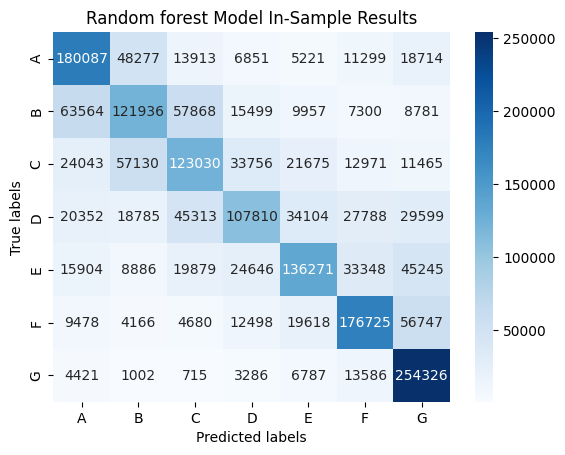

In [27]:
plot_confusion_matrix(y_train,insample_predictions,"Random forest Model In-Sample Results",['A', 'B'
                                                                                           ,'C','D',
                                                                                        'E','F','G'])

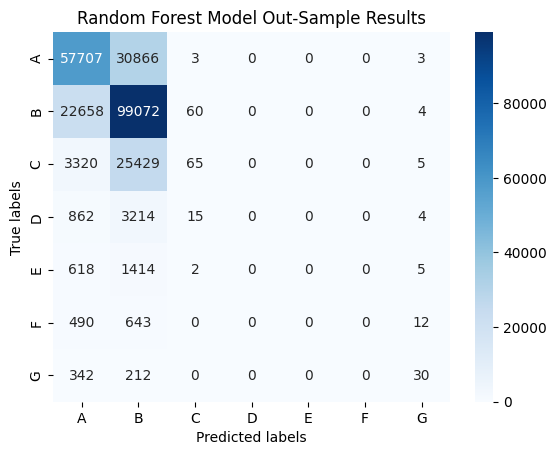

In [33]:
plot_confusion_matrix(y_test,outsample_predictions,"Random Forest Model Out-Sample Results",['A', 'B'
                                                                                                             ,'C','D',
                                                                                                             'E','F','G'])

  

-----------------------------------------------------------------------------------------------------------------------



-----------------------------------------------------------------------------------------------------------------------

### Logistic Model 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
logistic_model = make_pipeline(col_trans,LogisticRegression())
model  = logistic_model.fit(X_train, y_train)

/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = logistic_model.predict(X_train)
print("Logistic regression Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = logistic_model.predict(X_test)
print("Logistic regression Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

Logistic regression Insample Accuracy 34.17%
              precision    recall  f1-score   support

           A       0.51      0.41      0.46    348161
           B       0.34      0.36      0.35    263925
           C       0.35      0.36      0.35    274926
           D       0.15      0.26      0.19    158924
           E       0.21      0.23      0.22    250824
           F       0.21      0.25      0.23    235582
           G       0.64      0.40      0.49    456960

    accuracy                           0.34   1989302
   macro avg       0.34      0.33      0.33   1989302
weighted avg       0.39      0.34      0.36   1989302

Logistic regression Outsample Accuracy 34.10%
              precision    recall  f1-score   support

           A       0.50      0.41      0.46    148244
           B       0.34      0.36      0.35    112876
           C       0.35      0.36      0.35    118428
           D       0.14      0.26      0.18     67717
           E       0.21      0.23      0.

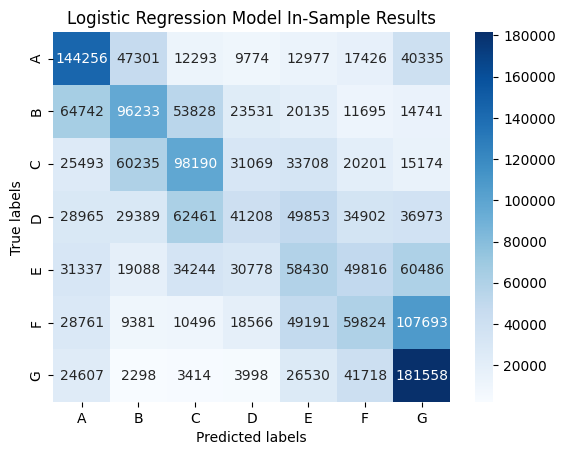

In [12]:
plot_confusion_matrix(y_train,insample_predictions,"Logistic Regression Model In-Sample Results",['A', 'B'
                                                                                                             ,'C','D',
                                                                                                             'E','F','G'])

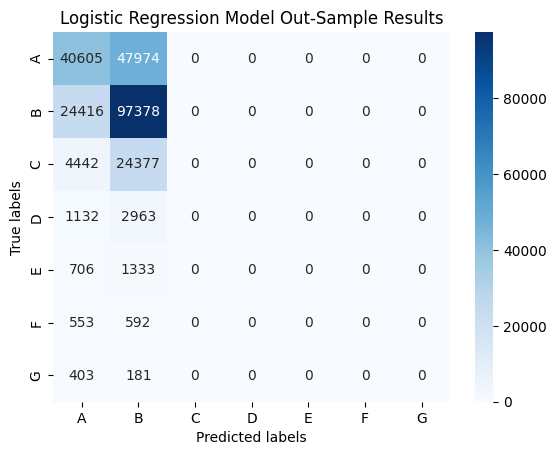

In [85]:
plot_confusion_matrix(y_test,outsample_predictions,"Logistic Regression Model Out-Sample Results",['A', 'B'
                                                                                                             ,'C','D',
                                                                                                             'E','F','G'])

In [46]:
import FeatureImportance

In [58]:
logistic_model.named_steps["logisticregression"].feature_importances_

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [53]:
logistic_model.named_steps['logisticregression'].coef_

array([[-5.40722022e-01,  6.03025519e-01, -3.08037458e-01,
         3.57869392e-01, -1.54149712e-01, -1.52848000e-01,
         6.29426769e-01,  9.73055431e-01,  3.67984219e-01,
        -3.59131419e-02, -1.68153525e-01,  8.56470726e-01,
         6.35183218e-02, -5.12284775e-01, -4.36480908e-01,
        -1.88138373e+00,  1.04801793e+00,  9.08887764e-01,
         1.00243189e+00,  1.25281524e+00,  4.04408274e-02,
        -7.33834756e-02, -2.67583254e-01,  9.08779339e-01,
         1.81409504e+00, -1.33764449e+00, -2.49524815e-01,
        -1.94937415e-01, -8.91862351e-03, -5.28757649e-01,
        -2.75750824e+00, -4.49021728e-01,  1.18807916e+00,
         9.10884503e-01,  1.36787827e+00,  1.74552682e-01,
        -1.31643456e-01, -1.42082143e+00, -2.23950284e+00,
         1.09630392e-01,  1.11613650e+00, -6.56742252e-01,
        -7.66535382e-01,  5.83728492e-01,  1.89150578e+00,
        -7.29230008e-02, -3.38064944e-02,  2.44416002e+00,
        -4.38913274e-01, -1.57044081e+00,  8.64917662e-0

### KNN


In [ ]:
#knn
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.model_selection import GridSearchCV

#tuning using gridsearch

knn = KNeighborsClassifier()

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_gscv = GridSearchCV(knn, hyperparameters, cv=5)
model_knn1=  knn_gscv.fit(X_train,y_train)
 
print(knn_gscv.best_params_)

In [ ]:
insample_predictions = model_knn1.predict(X_train)
print("Logistic regression Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = model_knn1.predict(X_test)
print("Logistic regression Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

### SVM

In [86]:
from sklearn import svm
svm =make_pipeline(col_trans,svm.SVC() ) 
svm.fit(X_train, y_train)

In [ ]:
insample_predictions = svm.predict(X_train)
print("Logistic regression Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = svm.predict(X_test)
print("Logistic regression Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

### Decision Tree 

1. with smote-nc

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth=200,min_samples_split=200,
                                  random_state = 20)
clf=make_pipeline(col_trans,dt)
clf = clf.fit(X_train, y_train)


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = clf.predict(X_train)
print("decision tree Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = clf.predict(X_test)
print("decision tree Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

decision tree Insample Accuracy 64.94%
              precision    recall  f1-score   support

           A       0.64      0.67      0.65    271350
           B       0.47      0.56      0.51    242446
           C       0.47      0.55      0.51    246650
           D       0.60      0.58      0.59    293724
           E       0.70      0.63      0.66    311488
           F       0.78      0.71      0.74    312475
           G       0.89      0.82      0.85    311169

    accuracy                           0.65   1989302
   macro avg       0.65      0.64      0.64   1989302
weighted avg       0.66      0.65      0.65   1989302

decision tree Outsample Accuracy 62.58%
              precision    recall  f1-score   support

           A       0.61      0.64      0.63    115237
           B       0.44      0.52      0.48    103999
           C       0.44      0.51      0.47    105995
           D       0.57      0.55      0.56    126378
           E       0.67      0.61      0.64    133089

2. original dataset

In [17]:
clf2= make_pipeline(col_trans, tree.DecisionTreeClassifier(max_depth=50,min_samples_split=200,
                                  random_state = 20))
clf2 = clf.fit(X_train2, y_train2)

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = clf2.predict(X_train2)
print("decision tree Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train2)))
print(classification_report(insample_predictions,y_train2))

outsample_predictions = clf2.predict(X_test2)
print("decision tree Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test2)))
print(classification_report(outsample_predictions,y_test2))

decision tree Insample Accuracy 66.03%
              precision    recall  f1-score   support

           A       0.69      0.70      0.70    202878
           B       0.80      0.65      0.72    349653
           C       0.16      0.46      0.23     22851
           D       0.02      0.47      0.03       370
           E       0.02      0.40      0.03       204
           F       0.01      0.33      0.02        81
           G       0.10      0.33      0.16       422

    accuracy                           0.66    576459
   macro avg       0.26      0.48      0.27    576459
weighted avg       0.73      0.66      0.69    576459

decision tree Outsample Accuracy 66.06%
              precision    recall  f1-score   support

           A       0.69      0.70      0.70     87098
           B       0.80      0.65      0.72    149544
           C       0.16      0.46      0.24      9946
           D       0.02      0.49      0.03       150
           E       0.01      0.31      0.03        93

xgbc


In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded = le.fit_transform(y_train)
y_train[10:20]

382581     B
254334     B
2313477    F
2224192    F
2692057    G
759922     C
1320506    D
532604     B
502084     B
2595550    G
Name: FIRE_SIZE_CLASS, dtype: object

In [29]:
encoded[10:20]

array([1, 1, 5, 5, 6, 2, 3, 1, 1, 6])

In [30]:
import xgboost as xgb

xgbc=xgb.XGBClassifier(objective='multi:softprob',
                       learning_rate =0.6,
                        n_estimators= 800,
                        max_depth=8,
                        min_child_weight=0,
                        gamma=0.2,
                        subsample=0.9,
                        colsample_bytree=0.7,
                        nthread=40,
                         seed=230)
xgbc_model = make_pipeline(col_trans,xgbc)
xgbc_model.fit(X_train,encoded)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['STAT_CAUSE_CODE', 'STATE']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'temp'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=Non...
                               feature_types=None, gamma=0.2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.6,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=0,
                               missing=nan, monotone_constraints=None,
                               n_estimators=800, n_jobs=None, nthread=40,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

use original dataset (without stonec transfrmation)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = le.inverse_transform(xgbc_model.predict(X_train))
print("xgbc Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = le.inverse_transform(xgbc_model.predict(X_test))
print("xgbc Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

xgbc Insample Accuracy 85.92%
              precision    recall  f1-score   support

           A       0.82      0.83      0.83    277764
           B       0.74      0.75      0.74    281496
           C       0.72      0.79      0.76    259184
           D       0.86      0.87      0.86    279951
           E       0.92      0.89      0.91    293426
           F       0.96      0.91      0.94    299664
           G       0.99      0.95      0.97    297817

    accuracy                           0.86   1989302
   macro avg       0.86      0.86      0.86   1989302
weighted avg       0.86      0.86      0.86   1989302

xgbc Outsample Accuracy 76.65%
              precision    recall  f1-score   support

           A       0.69      0.71      0.70    118712
           B       0.58      0.59      0.58    119712
           C       0.58      0.65      0.61    108482
           D       0.76      0.78      0.77    118747
           E       0.86      0.83      0.84    126158
           F     

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = le.inverse_transform(xgbc_model.predict(X_train2))
print("xgbc Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train2)))
print(classification_report(insample_predictions,y_train2))


xgbc Insample Accuracy 70.93%
              precision    recall  f1-score   support

           A       0.78      0.78      0.78    206272
           B       0.69      0.79      0.74    249064
           C       0.58      0.48      0.52     81299
           D       0.60      0.33      0.42     17534
           E       0.70      0.31      0.43     10689
           F       0.78      0.28      0.41      7529
           G       0.85      0.29      0.43      4072

    accuracy                           0.71    576459
   macro avg       0.71      0.46      0.53    576459
weighted avg       0.71      0.71      0.70    576459

xgbc Outsample Accuracy 70.94%


ValueError: Found input variables with inconsistent numbers of samples: [247055, 852558]

In [33]:

outsample_predictions = le.inverse_transform(xgbc_model.predict(X_test2))
print("xgbc Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test2)))
print(classification_report(outsample_predictions,y_test2))

xgbc Outsample Accuracy 70.94%
              precision    recall  f1-score   support

           A       0.78      0.78      0.78     88296
           B       0.69      0.79      0.74    107090
           C       0.58      0.48      0.52     34747
           D       0.59      0.33      0.42      7417
           E       0.69      0.30      0.42      4594
           F       0.74      0.27      0.39      3164
           G       0.87      0.29      0.44      1747

    accuracy                           0.71    247055
   macro avg       0.70      0.46      0.53    247055
weighted avg       0.71      0.71      0.70    247055



ROC and AUC

In [27]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

ValueError: multi_class must be in ('ovo', 'ovr')